Projekt Vizualizácia
---

Téma: Psy

Skupina Číslo: 10
Skupina Názov: Gormiti

Členovia: Adam Mjartan, Martin Bakus, Norbert Riebesam, Timotej Vida, Michal Salčík

Použité Datasety (linky):

- Hlavný Dataset: https://figshare.com/ndownloader/files/27715521
- Geografické Dáta: https://worldostats.com/country-stats/dog-population-by-country/



Dodatočné Zdroje:



Import Použitých Knižníc

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
import geopandas as gpd
import numpy as np

Načítanie Použitých Datasetov

In [77]:
main_data = pd.read_excel(r'https://figshare.com/ndownloader/files/27715521', sheet_name='Dataset')
main_data_information = pd.read_excel(r'https://figshare.com/ndownloader/files/27715521', sheet_name='Information')
population_data = pd.read_csv(r"https://raw.githubusercontent.com/P3rfectS/Data/refs/heads/main/World%20Population%20by%20country%202024.csv")
#geografical_data = pd.read_csv(r"https://raw.githubusercontent.com/P3rfectS/Data/refs/heads/main/Dog%20Population%20by%20Country.csv")
geografical_data = pd.read_csv("Misov Priestor/data/Dog Population by Country.csv")
world_geography = gpd.read_file(r"https://github.com/P3rfectS/Data/raw/refs/heads/main/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

Príprava Vizuálnych Podkladov
---

Príprava: Geografické Dáta
---

#1 transofmácia, čistenie a doplnenie datasetu

In [78]:
#Odstránenie chybných dát
geografical_data = geografical_data[geografical_data["Country"] != 'Montenegro']

#Doplnenie chýbajúcich dát (tvorba dočasného df)
#new_row = pd.DataFrame([{"Country": "Australia", "Estimated Dog Population": "6000000"}])

#Pripojenie ku pôvodnému datasetu
#geografical_data = pd.concat([geografical_data, new_row], ignore_index=True)


#Zmena tipu dát na numerické
geografical_data['Estimated Dog Population'] = pd.to_numeric(
    geografical_data['Estimated Dog Population'].str.replace(',', ''),
    errors='coerce'
)

#Úprava názvov štátov v datasete aby zodpovedali názvom ktoré používa funkcia
country_name_fixes = {
    "Swaziland": "Eswatini",
    "Democratic Republic of Congo": "DR Congo",
    "Kosovo": "Kosovo",
    "United States of America": "United States",
    "Czech Republic": "Czechia",
    "United States": "United States of America",
    "Bosnia and Herzegovina": "Bosnia and Herz."
}
geografical_data['Country'] = geografical_data['Country'].replace(country_name_fixes)
population_data['Country'] = population_data['Country'].replace(country_name_fixes)

#2 Tvorba zjednotených tabuľiek

In [79]:
#Tvorba zjednotenej tabulky
full_table = geografical_data.merge(population_data, on='Country', how='left')
full_table['Dog Population per Capita'] = full_table['Estimated Dog Population'] / full_table['Population 2024']
#Tvorba tabuliek pre vizualizácie
merged = world_geography.merge(geografical_data, how='left', left_on='NAME', right_on='Country')
merged["Estimated Dog Population log"] = np.log10(merged["Estimated Dog Population"])
merged_per_capita = world_geography.merge(full_table, how='left', left_on='NAME', right_on='Country')

#3 Tvorba jednotlivých vizualizácií

C:\Users\Legion\AppData\Local\Temp\ipykernel_4380\3039830611.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_yticklabels([f"10^{val:,}" for val in tick_values])


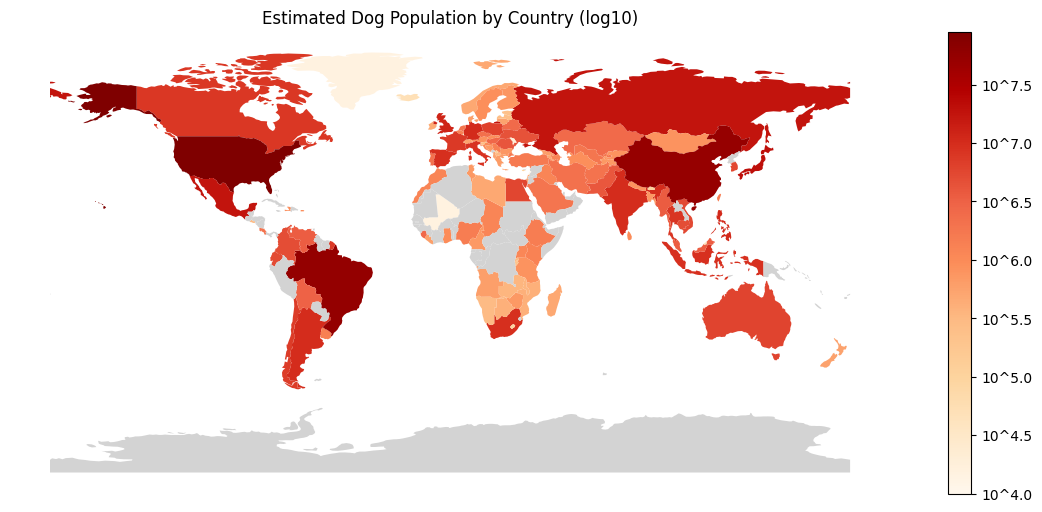

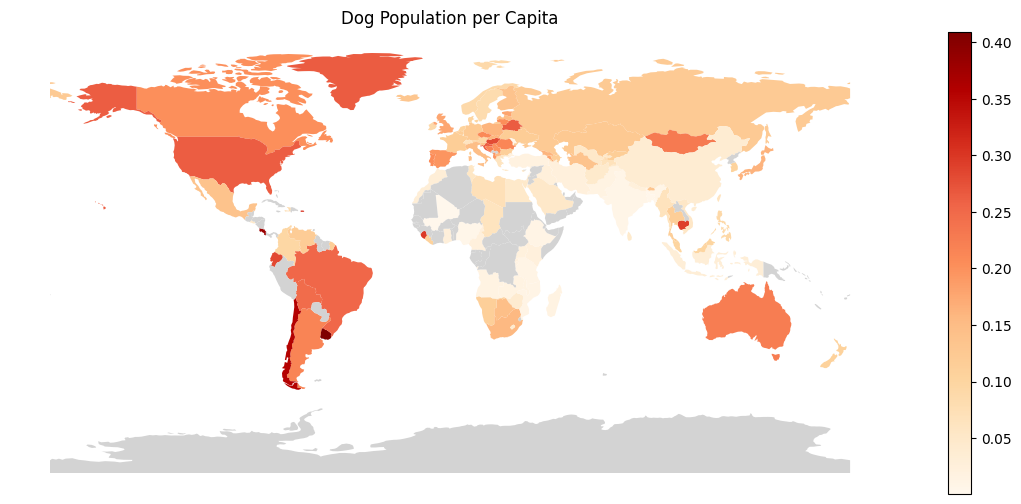

In [80]:
#Funkcia pre vytvorenie geografickej vizualizácie psej populácie v rôznych krajinách sveta
def geo_vytvor_populacia_psov():
    fig, ax = plt.subplots(figsize=(15, 6))
    mapa = merged.plot(
        column='Estimated Dog Population log',
        ax=ax,
        legend=True,
        cmap='OrRd',
        missing_kwds={"color": "lightgrey", "label": "No data"}
    )
    cbar = mapa.get_figure().get_axes()[-1]
    tick_values = cbar.get_yticks()
    cbar.set_yticklabels([f"10^{val:,}" for val in tick_values])

    plt.title("Estimated Dog Population by Country (log10)")
    plt.axis('off')
    plt.show()

#Funkcia pre vytvorenie geografickej vizualizácie populácie psov na jedného obyvateľa v rôznych krajinách sveta
def geo_vytvor_psy_na_hlavu():
    fig, ax = plt.subplots(figsize=(15, 6))
    merged_per_capita.plot(
    column='Dog Population per Capita',
    ax=ax,
    legend=True,
    cmap='OrRd',
    missing_kwds={"color": "lightgrey", "label": "No data"}
    )
    plt.title("Dog Population per Capita")
    plt.axis('off')
    plt.show()

geo_vytvor_populacia_psov()
geo_vytvor_psy_na_hlavu()
#HUSTOTA NA KM4

Príprava: Predstavenie Datasetu // Dataset Bias
---